In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from numpy import mean
from numpy import std
from numpy import dstack
from numpy import concatenate
from numpy import array
from numpy import argmax
from numpy import arange
from pandas import read_csv
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from plot import LearningPlotCallback

import time

import matplotlib.pyplot as plt

In [4]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None)

    return dataframe.values

In [5]:
def load_data(files, group, window, stride):

    #print(len(files))
    X = array([]).reshape(0,window,2)
    y = array([]).reshape(0,1)
    for file in files:
        file_feature_X1_name = 'Dataset_Window/' + group + '/' + file + '_X_1_w_' + str(window) + '_s_' + str(stride) + '.csv'  
        file_feature_X2_name = 'Dataset_Window/' + group + '/' + file + '_X_2_w_' + str(window) + '_s_' + str(stride) + '.csv'  
        file_label_name = 'Dataset_Window/' + group + '/' + file + '_y_w_' + str(window) + '_s_' + str(stride) + '.csv'  
        
        X_loaded = list()

        X_loaded.append(load_file(file_feature_X1_name))
        X_loaded.append(load_file(file_feature_X2_name))
        X_loaded = dstack(X_loaded)
        X = concatenate((X, X_loaded),axis=0)

        y_loaded = load_file(file_label_name)

        y = concatenate((y, y_loaded))
        #print("X ",X_loaded.shape)
        #print("y ",y_loaded.shape)
    print(group)
    print("X ",X.shape)
    print("y ",y.shape)

    y_encoded = to_categorical(y)
    #print(y_encoded)
    print("y_encoded ",y_encoded.shape)
    return X, y_encoded, y

In [6]:
def train_model(X_train, y_train, model_path, window,epochs):

    verbose, epochs, batch_size = 1, epochs, 128
    n_features, n_outputs = X_train.shape[2], y_train.shape[1]


    n_steps, n_length = 1, window
    X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))


    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=11, activation='relu', padding="same"),
    input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Dropout(0.9)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding="same")))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    # fit network
    print("Training...")
    #history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[LearningPlotCallback()])
    print(history.history.keys())
    model.save(model_path)

In [7]:
def evaluate_model(X_test, y_test, model_path,window):
    n_steps, n_length = 1, window
    batch_size = 128
    n_features, n_outputs = X_test.shape[2], y_test.shape[1]
    X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
    model = load_model(model_path)

    results = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print("test loss, test acc:", results)

    predictions = model.predict(X_test)
    print("predictions shape:", predictions.shape)
    #print(predictions)

    #predictions[predictions <= 0.5] = 0.
    #predictions[predictions > 0.5] = 1.
    #print(predictions)

    class_labels = argmax(predictions, axis=1)
    print(class_labels)
    print(len(class_labels))
    # predictions = model.predict(X_test)

    return class_labels

In [8]:
def train(model_path, prefix_train_data, window, stride, epochs):
    
    X_train, y_train, _ = load_data(prefix_train_data , 'Train_Set', window, stride)
    train_model(X_train, y_train, model_path, window,epochs)

In [9]:
def test(model_path,perfix_test_data,window, stride):
    #print(len(perfix_test_data))
    #print(perfix_test_data)

    y_set = list()

    for prefix in perfix_test_data:
        #print(prefix)
        X_test, y_test, y_law = load_data([prefix] , 'Test_Set', window, stride)

        
        y_predic = evaluate_model(X_test, y_test, model_path, window)

        y_law = y_law.reshape(1,-1)
        list_y_law = y_law[0].tolist()
        #s = arange(0,len(y_predic),1)
        y_set.append([y_predic,list_y_law])

    plt.figure(figsize=(12,7))
    for i in range(len(y_set)):
        ax = plt.subplot(2,3,i+1)
        ax.set_title(perfix_test_data[i])
        ax.plot(y_set[i][0],'r')
        ax.plot(y_set[i][1],'b')
        #plt.title.set_text(perfix_test_data[i])

    plt.show()

### Parameters


In [14]:

window = 32
stride = 8
epochs = 10

model_path = 'model/model_' + str(window) + "_" + str(stride)
    
prefix_train_data = ['B11','B12']

perfix_test_data = ['B13', 'B14','B15','B16','B17']

### Train

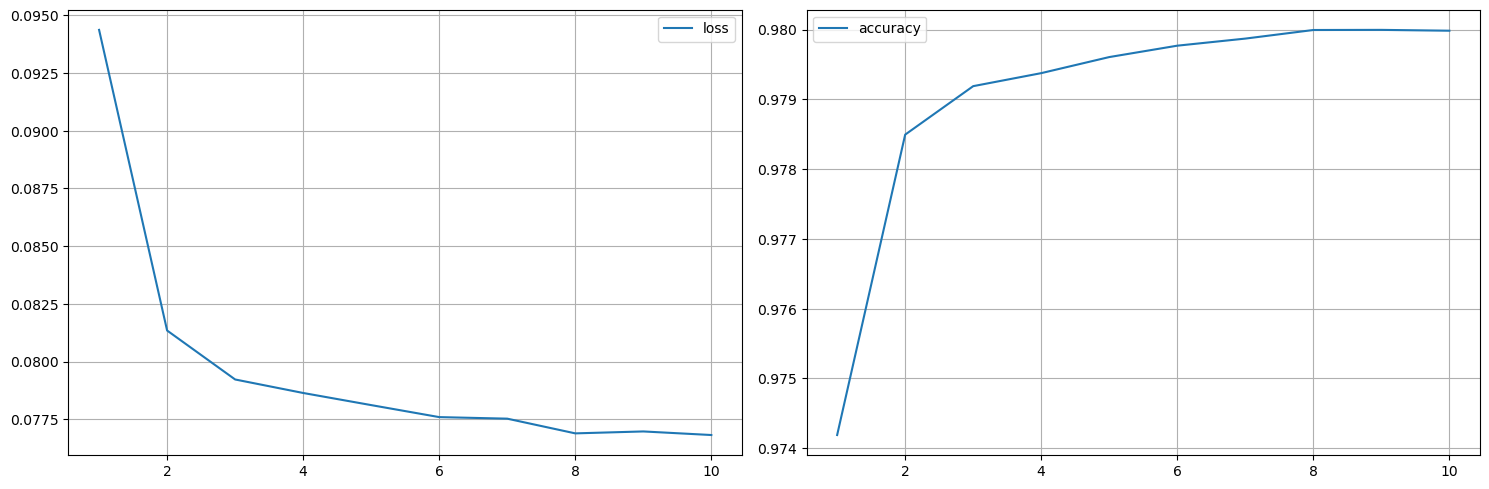

8380/8380 [==============================] - 38s 5ms/step - loss: 0.0768 - accuracy: 0.9800
dict_keys(['loss', 'accuracy'])


INFO:tensorflow:Assets written to: model/model_32_8/assets


INFO:tensorflow:Assets written to: model/model_32_8/assets


In [16]:
### Train ###
train(model_path, prefix_train_data, window, stride, epochs)

### Test

Test_Set
X  (42, 32, 2)
y  (42, 1)
y_encoded  (42, 2)
1/1 [==============================] - 0s 278ms/step - loss: 1.4174 - accuracy: 0.6667
test loss, test acc: [1.4174031019210815, 0.6666666865348816]
2/2 [==============================] - 1s 13ms/step
predictions shape: (42, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0]
42
Test_Set
X  (32, 32, 2)
y  (32, 1)
y_encoded  (32, 2)
1/1 [==============================] - 0s 250ms/step - loss: 0.0158 - accuracy: 1.0000
test loss, test acc: [0.01579938270151615, 1.0]
1/1 [==============================] - 0s 193ms/step
predictions shape: (32, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
32
Test_Set
X  (33, 32, 2)
y  (33, 1)
y_encoded  (33, 2)
1/1 [==============================] - 0s 245ms/step - loss: nan - accuracy: 0.9697
test loss, test acc: [nan, 0.9696969985961914]
2/2 [==============================] - 0s 12ms/step
predictions shape: (33, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1

1/1 [==============================] - 0s 261ms/step - loss: 2.2714 - accuracy: 0.4746
test loss, test acc: [2.2713675498962402, 0.47457626461982727]


2/2 [==============================] - 0s 17ms/step
predictions shape: (59, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
59


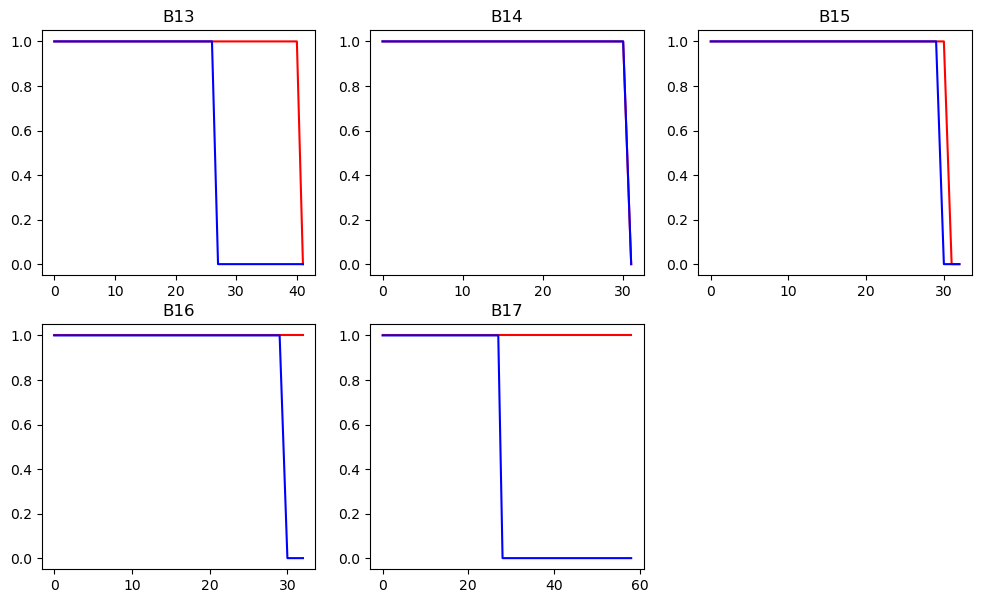

In [13]:
### Test ###
test(model_path,perfix_test_data,window, stride)